# Adapt VQE

The goal is to perform a variational preparation of the ground state of the large-N (1,2,1) Hamiltonian

$$ H_E =  g^2 \left( N_c - \frac{1}{N_c} \right)\left[ \sum_p  P_{1,p} - \frac{1}{2}\sum_p \sum_{\hat{n}} P_{1,p} P_{1,p+\hat{n}} \right] $$

$$ H_B = -\frac{1}{\sqrt{2}g^2} \sum_{p} \left( \prod_{\hat{n}} P_{0,p+\hat{n}} \right) X_p - \frac{1}{2g^2 N_c} \sum_{p} \sum_{\hat{k}} P_{1,p+\hat{k}} \left( \prod_{\hat{n}\neq\hat{k}} P_{0,p+\hat{n}} \right) X_p $$

where $P_0 = |0\rangle\langle 0|$ and $P_1 = |1\rangle\langle 1 |$, where the sum over $\hat{n}$ is a sum over lattice unit vectors.

The algorithm of choice will be ADAPT-VQE.

### Operator pool

The pool of operators is constrained by the symmetries of the ground state and the types of interactions in the Hamiltonian. With periodic boundary conditions, the Hamiltonian is translation invariant. In addition, we must respect CP symmetry and (as a result of CPT invariance) T symmetry. Because of T symmetry, the ground state wave function should be real. We will start with the most local operators, and add increasingly non-local operators until the ansatz is expressive enough to get errors below our tolerence.

To start off with, the operator pool will be:

$$ \{ "P_0 P_0 P_0 P_0 Y", "P_0 P_0 P_0 P_1 Y" \}. $$

These operators in quotation marks are shorthand for the operators that make up the magnetic Hamiltonian, except with $X$ swapped out for $Y$ in order to make the wave function real. More operators can be added later if the performance is not good enough.

In [2]:
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
import random

## Code for creating the Hamiltonian

Helper functions

In [3]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Define functions that implements the operators in the Hamiltonian.
Want to work with sparse matrices.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

# Create the one-qubit operations
Id =  sparse.csc_matrix(np.array([[1.,0.],[0.,1.]]))
P1 = sparse.csc_matrix(np.array([[0., 0.],[0., 1.]]))
P0 = sparse.csc_matrix(np.array([[1.,0.],[0.,0.]]))
Xop = sparse.csc_matrix(np.array([[0.,1.],[1.,0.]]))
Yop = sparse.csc_matrix(np.array([[0.,-1.j],[1.j,0.]]))


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
A function that acts with a one-qubit operator on a specified qubit. So, it takes in a 2x2 matrix and spits out a 2^n x 2^n matrix.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def one_qubit_gate( M: sparse._csc.csc_matrix, p: int, n: int) -> sparse._csc.csc_matrix:
    if (M.shape != (2,2)):
        print('Warning: Expected M argument to be a 2x2 sparse matrix.')
    if ( p<0 or p>=n ):
        print(f'Warning: Expected p argument to be within the range [0, {n}-1] inclusive.')

    result = sparse.eye(1, format='csc') # create a sparse 1x1 matrix to store result
    for i in range(n):
        if (i==p):
            result = sparse.kron(result, M, format='csc')
        else:
            result =sparse.kron(result, Id, format='csc')  
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    Define a function that returns an n-qubit gate that is in the form of a tensor product of single qubit gates.

    Expects the dictionary op_dict to be of the form { p1: M1, p2: M2, p3: M3 } where the p's are integers specifying
    qubits and the M's are 2x2 matrices in sparse format specifying one-qubit gates.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def multi_qubit_gate( op_dict: dict, n: int) -> sparse._csc.csc_matrix:
    result = sparse.eye(1, format='csc') # Create a 1x1 in sparse format to build our operator
    for i in range(n):
        if i in op_dict:
            result =sparse.kron(result, op_dict[i], format='csc')
        else:
            result =sparse.kron(result, Id, format='csc')
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Convert between the single-index p which enumerates qubits, and double-index (i,j) which enumerates lattice sites
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def map_to_circuit( i, j, L, H ):
    if i >= L:
        print(f"[map_to_circuit] i index out of bounds: expected i<{L}, but i={i}")
    if j >= H:
        print(f"[map_to_circuit] j index out of bounds, expected j<{H}, but j={j}")
    
    return j*L + i


def map_to_lattice( p, L, H ):
    if p >= (L*H):
        print(f"[map_to_lattice] p index out of bounds, expected p<{L*H}, but p={p}")

    return p % L, p // L


def get_neighbours( p, lat_shape, boundary='periodic' ):
    L, H = lat_shape
    i, j = map_to_lattice(p, L, H)
    if boundary == 'periodic':
        nl   = map_to_circuit((i - 1) % L, j, L, H)
        nd   = map_to_circuit(i, (j - 1) % H, L, H)
        nr   = map_to_circuit((i + 1) % L, j, L, H)
        nu   = map_to_circuit(i, (j + 1) % H, L, H)
        return nl, nd, nr, nu
    elif boundary == 'open':
        if i == 0:
            nl = None
        else:
            nl = map_to_circuit(i - 1, j, L, H)
        if j == 0:
            nd = None
        else:
            nd = map_to_circuit(i, j - 1, L, H)
        if i == L - 1:
            nr = None
        else:
            nr = map_to_circuit(i + 1, j, L, H)
        if j == H - 1:
            nu = None
        else:
            nu = map_to_circuit(i, j + 1, L, H)
        return nl, nd, nr, nu


# A function that applies the specified operator to every qubit in the lattice, and then returns the resulting matrix
def sigma(op_name, lat_shape, boundary='periodic'):
    L = lat_shape[0]
    H = lat_shape[1]
    n = L*H

    op = sparse.csc_matrix((2**n, 2**n))

    if boundary == "periodic":

        if op_name == "P1":
            for p in range(n):
                op += one_qubit_gate(P1, p, n)

        elif op_name == "P1P1":
            for p in range(n):
                i, j = map_to_lattice(p, L, H)
                nr   = map_to_circuit((i + 1) % L, j, L, H)
                nu   = map_to_circuit(i, (j + 1) % H, L, H)
                op = multi_qubit_gate( {p: P1, nr: P1}, n )
                op+= multi_qubit_gate( {p: P1, nu: P1}, n )

        elif op_name == "P0P0P0P0X":
            for p in range(n):
                nl, nd, nr, nu = get_neighbours(p, lat_shape)
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P0}, n )

        elif op_name == "P0P0P0P1X":
            for p in range(n):
                nl, nd, nr, nu = get_neighbours(p, lat_shape)
                op += multi_qubit_gate( {p: Xop, nl: P1, nd: P0, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P1, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P1, nu: P0}, n )
                op += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P1}, n )
        
        elif op_name == "P0P0P0P0Y":
            for p in range(n):
                nl, nd, nr, nu = get_neighbours(p, lat_shape)
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P0, nr: P0, nu: P0}, n )
        
        elif op_name == "P0P0P0P1Y":
            for p in range(n):
                nl, nd, nr, nu = get_neighbours(p, lat_shape)
                op += multi_qubit_gate( {p: Yop, nl: P1, nd: P0, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P1, nr: P0, nu: P0}, n )
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P0, nr: P1, nu: P0}, n )
                op += multi_qubit_gate( {p: Yop, nl: P0, nd: P0, nr: P0, nu: P1}, n )
        else:
            raise ValueError(f"Unknown operator name: {op_name}")
    
    elif boundary == "open":
        raise NotImplementedError("Open boundary conditions not implemented yet.")
    
    return op


Functions for creating the Hamiltonian

In [4]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''' 
Create a function that produces the Hamiltonian matrix
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def make_electric_ham(g: float, lat_shape: list, boundary: str = 'periodic', N_colors: int = 3 ) -> sparse._csc.csc_matrix:
    H_E = sigma('P1', lat_shape, boundary)
    H_E -= 0.5 * sigma('P1P1', lat_shape, boundary)
    return (N_colors - 1/N_colors)*g*g * H_E


def make_magnetic_ham( g: float, lat_shape: tuple, boundary='periodic', N_colors: int = 3) -> sparse._csc.csc_matrix:
    coeff1 = -np.sqrt(2)/(2*g*g)
    coeff2 = -1/(2*g*g*N_colors)
    H_B1 = sigma('P0P0P0P0X', lat_shape, boundary)
    H_B2 = sigma('P0P0P0P1X', lat_shape, boundary)
    return coeff1 * H_B1  +   coeff2 * H_B2


def make_ham(g: float, lat_shape: tuple, boundary: str ='periodic', N_colors: int =3 ) -> sparse._csc.csc_matrix:
    HE = make_electric_ham(g, lat_shape, boundary, N_colors)
    HB = make_magnetic_ham(g, lat_shape, boundary, N_colors)
    return HE + HB


def get_ground_state_energy(g, lat_shape, boundary='periodic', N_colors=3):
    H = make_ham(g, lat_shape, boundary, N_colors)
    evals, evecs = sparse.linalg.eigsh( H, which='SA', k=1)
    return evals[0]

def get_ground_state(g, lat_shape, boundary='periodic', N_colors=3):
    H = make_ham(g, lat_shape, boundary, N_colors)
    _, evecs = sparse.linalg.eigsh( H, which='SA', k=1)
    return evecs[:,0] / np.linalg.norm(evecs[:,0]) # Normalize the ground state vector


## Ground state prep

Walk through the steps and do a sanity check

In [5]:
def get_operator_pool(op_names, lat_shape, boundary="periodic"):
    op_pool = [sigma(op_name, lat_shape, boundary) for op_name in op_names]
    return op_pool

In [6]:
g = 1.
lat_shape = (3,3)
boundary = 'periodic'

op_names = ['P0P0P0P0Y', 'P0P0P0P1Y']

In [7]:
operator_pool = get_operator_pool(op_names, lat_shape, boundary)

In [8]:
imag_operator_pool = [op.imag for op in operator_pool]

In [9]:
H = make_ham(g, lat_shape)
H = H.real

In [10]:
commutator_pool = [-(H @ op - op @ H) for op in imag_operator_pool]

In [11]:
def construct_electric_vac(lat_shape):
    n = lat_shape[0]*lat_shape[1]
    return sparse.csc_matrix( ([1] + [0]*(2**n - 1)) ).T

In [12]:
electric_vac = construct_electric_vac(lat_shape)

In [13]:
def expectation_value(state, op):
    return (state.T.conj() @ (op @ state)).sum().real

In [14]:
ips = np.array([expectation_value(electric_vac, op) for op in commutator_pool])

In [15]:
min_op = imag_operator_pool[random.choice(np.where(ips == np.max(np.abs(ips)))[0])] 

In [16]:
eps_vals = np.linspace(0, 1, 100)
energies = []

for i, eps in enumerate(eps_vals):
    U = sp.sparse.linalg.expm( min_op * eps )
    new_state = U @ electric_vac
    energies.append( expectation_value(new_state, H) )

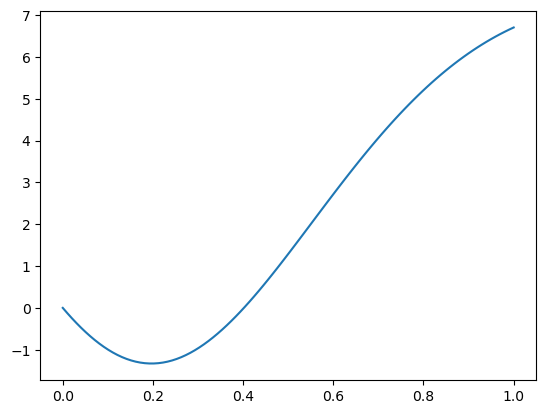

In [17]:
# plot the energies
plt.plot(eps_vals, energies)

In [18]:
def objective_function(eps):
    U = sp.sparse.linalg.expm( min_op * eps[0] )
    new_state = U @ electric_vac
    return expectation_value(new_state, H)

eps0 = [0]

sol = sp.optimize.minimize(objective_function, eps0)

In [19]:
sol

      fun: -1.32997004332702
 hess_inv: array([[0.01402744]])
      jac: array([-4.47034836e-08])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([0.19690845])

## ADAPT-VQE Algorithm

Compactify the process into one function

In [20]:
'''Helper functions'''


# These ones only require lattice size information

def get_operator_pool(op_names, lat_shape, boundary="periodic"):
    op_pool = [sigma(op_name, lat_shape, boundary) for op_name in op_names]
    return op_pool

def get_imag_operator_pool(op_names, lat_shape, boundary="periodic"):
    operator_pool = get_operator_pool(op_names, lat_shape, boundary)
    return [op.imag for op in operator_pool]

def construct_electric_vac(lat_shape):
    n = lat_shape[0]*lat_shape[1]
    return sparse.csc_matrix( ([1] + [0]*(2**n - 1)) ).T

def expectation_value(state, op):
    return (state.T.conj() @ (op @ state)).sum().real

# These ones require the coupling / hamiltonian

def get_commutator_pool(H, imag_operator_pool):
    return [-(H @ op - op @ H) for op in imag_operator_pool]


In [21]:
def opt_step(psi_prev, epss_prev, indices_prev, H, lat_shape, commutator_pool, psi_0, imag_operator_pool):
    n = lat_shape[0]*lat_shape[1]

    ips = np.array([expectation_value(psi_prev, op) for op in commutator_pool])
    min_index = random.choice(np.where(ips == np.max(np.abs(ips)))[0])
    new_indices = np.append( indices_prev.astype(int), int(min_index) )
    new_epss = np.append(epss_prev, 0.01)

    def ansatz(epss):
        U = sp.sparse.eye(2**n, format="csc")
        for eps, idx in zip(epss, new_indices):
            U = sp.sparse.linalg.expm( eps * imag_operator_pool[idx]) @ U
        return U @ psi_0
    
    def objective_ev(epss):
        new_state = ansatz(epss)
        return expectation_value(new_state, H)
    
    sol = sp.optimize.minimize(objective_ev, new_epss)
    opt_epss = sol["x"]
    new_energy = sol["fun"]
    new_state = ansatz(opt_epss)

    return new_indices, new_state, opt_epss, new_energy

In [22]:
def adapt_vqe(g, lat_shape, boundary="periodic", N_colors=3, op_pool_names=["P0P0P0P0Y", "P0P0P0P1Y"], delta_E=0.0001):

    H = make_ham(g, lat_shape, boundary, N_colors)
    imag_operator_pool = get_imag_operator_pool(op_pool_names, lat_shape, boundary)
    commutator_pool = get_commutator_pool(H, imag_operator_pool)

    # store results
    psi_0 = construct_electric_vac(lat_shape)
    epss = []
    indices = []
    energies = []

    # use in loop
    new_state = psi_0
    opt_epss = np.array(epss)
    new_indices = np.array(indices)

    while True:
        new_indices, new_state, opt_epss, new_energy = opt_step(new_state, opt_epss, new_indices, H, lat_shape, commutator_pool, psi_0, imag_operator_pool)
        indices.append( new_indices[-1] )
        epss.append( opt_epss )
        energies.append( new_energy )
        if len(energies) > 2 and abs(energies[-1] - energies[-2]) <= delta_E:
            break
    
    return energies, indices, epss, new_state

Example usage:

In [23]:
'''
input data
'''
g = 1.1
lat_shape = (3,3)
boundary="periodic"
N_colors = 3


'''
hyper-parameters
'''
op_pool =["P0P0P0P0Y", "P0P0P0P1Y"]
delta_E = 0.01


energies, indices, epss, new_state = adapt_vqe(g, lat_shape, boundary, N_colors, op_pool, delta_E)

In [24]:
ground_state = get_ground_state(g, lat_shape, boundary, N_colors)

def fidelity(psi, phi):
    return np.abs( (psi.T.conj() @ phi).sum() )**2

fidelity(new_state, ground_state)

0.9999860422578627

In [25]:
energies[-1] - get_ground_state_energy(g, lat_shape)

9.64847793308854e-05

## Trotterized Ansatz

In its current form, the ansatz is not quantum hardware implementable, and it is also quite costly on a classical computer (beyond the inherent exponentially bad scaling that is.) These problems are ameliorated by trotterizing the operators that generate the ansatz:

$$ \exp\bigg(i \varepsilon \sum_p \mathcal{O}_p \bigg) \longmapsto \prod_p \exp(i \varepsilon \mathcal{O}_p) + O(\varepsilon^2) $$

The trotterization can be made two-site translation invariant by grouping the product by even and odd sites. In addition, for the operators we are using (of the form $PY$ where $P$ is a projection operator $P^2=P$ that acts on up to four qubits), we have the identity

$$ \exp(i Y_p P) = \exp(i Y_p) P + (1 - P) $$

which lets us prepare the sparse operator $\exp(i Y_p P)$ in an efficient way.


In [26]:
def make_U_trotterized(eps, op_name, lat_shape):
    n = lat_shape[0]*lat_shape[1]
    RY = np.cos(eps)*Id + 1j*np.sin(eps)*Yop
    U = sparse.eye(2**n, format="csc")
    
    if op_name == "P0P0P0P0Y":
        for p in range(n):
            nl, nd, nr, nu = get_neighbours(p, lat_shape)
            P = multi_qubit_gate({nl: P0, nr: P0, nu: P0, nd: P0}, n)
            trotter_step = one_qubit_gate( RY, p, n )@P + (sp.sparse.eye(2**n, format='csc') - P)
            U = trotter_step @ U
    
    elif op_name == "P0P0P0P1Y":
        for p in range(n):
            nl, nd, nr, nu = get_neighbours(p, lat_shape)
            P =  multi_qubit_gate({nl: P1, nr: P0, nu: P0, nd: P0}, n)
            P += multi_qubit_gate({nl: P0, nr: P1, nu: P0, nd: P0}, n)
            P += multi_qubit_gate({nl: P0, nr: P0, nu: P1, nd: P0}, n)
            P += multi_qubit_gate({nl: P0, nr: P0, nu: P0, nd: P1}, n)
            trotter_step = one_qubit_gate( RY, p, n )@P + (sp.sparse.eye(2**n, format='csc') - P)
            U = trotter_step @ U
    else:
        raise ValueError(f"Unknown operator name: {op_name}")
    
    return U


In [27]:
def opt_step_trotterized(psi_prev, epss_prev, indices_prev, H, lat_shape, commutator_pool, psi_0, op_pool_names):
    n = lat_shape[0]*lat_shape[1]
    ips = np.array([expectation_value(psi_prev, op) for op in commutator_pool])
    min_index = random.choice(np.where(ips == np.max(np.abs(ips)))[0])
    new_indices = np.append( indices_prev.astype(int), int(min_index) )
    new_epss = np.append(epss_prev, 0.01)

    def ansatz(epss):
        U = sp.sparse.eye(2**n, format="csc")
        for eps, idx in zip(epss, new_indices):
            U = make_U_trotterized(eps, op_pool_names[idx], lat_shape) @ U
        return U @ psi_0
    
    def objective_ev(epss):
        new_state = ansatz(epss)
        return expectation_value(new_state, H)
    
    sol = sp.optimize.minimize(objective_ev, new_epss)
    opt_epss = sol["x"]
    new_energy = sol["fun"]
    new_state = ansatz(opt_epss)

    return new_indices, new_state, opt_epss, new_energy

In [28]:
def adapt_vqe_trotterized(g, lat_shape, boundary="periodic", N_colors=3, op_pool_names=["P0P0P0P0Y", "P0P0P0P1Y"], delta_E=0.0001):

    H = make_ham(g, lat_shape, boundary, N_colors)
    imag_operator_pool = get_imag_operator_pool(op_pool_names, lat_shape, boundary)
    commutator_pool = get_commutator_pool(H, imag_operator_pool)

    # store results
    psi_0 = construct_electric_vac(lat_shape)
    epss = []
    indices = []
    energies = []

    # use in loop
    new_state = psi_0
    opt_epss = np.array(epss)
    new_indices = np.array(indices)

    while True:
        new_indices, new_state, opt_epss, new_energy = opt_step_trotterized(new_state, opt_epss, new_indices, H, lat_shape, commutator_pool, psi_0, op_pool_names)
        indices.append( new_indices[-1] )
        epss.append( opt_epss )
        energies.append( new_energy )
        if len(energies) > 2 and abs(energies[-1] - energies[-2]) <= delta_E:
            break
    
    return energies, indices, epss, new_state

In [ ]:
'''
input data
'''
g = 1.1
lat_shape = (3,5)
boundary="periodic"
N_colors = 3


'''
hyper-parameters
'''
op_pool =["P0P0P0P0Y", "P0P0P0P1Y"]
delta_E = 0.01


energies, indices, epss, new_state = adapt_vqe_trotterized(g, lat_shape, boundary, N_colors, op_pool, delta_E)

In [30]:
ground_state = get_ground_state(g, lat_shape, boundary, N_colors)

def fidelity(psi, phi):
    return np.abs( (psi.T.conj() @ phi).sum() )**2

fidelity(new_state, ground_state)

0.9999688959384956

In [31]:
true_energy = get_ground_state_energy(g, lat_shape, boundary, N_colors)

energies[-1] - true_energy

0.0001875163680611358

## Precompute a dictionary of all physical and unphysical states

The code-snippet below will load the file (by default named ```is_physical_dict.pkl```) into the variable ```is_physical_dict```, or, if the file does not yet exist, it creates the file and populates it with data.

Also includes the function ```is_physical_state_from_vector( np_array, lat_shape )``` to determine whether a general state is physical or not.

In [32]:
def is_physical_state( binary_str, lat_shape ):
    # Convert the binary string into a binary array
    binary_array = binary_array_from_list( binary_str, lat_shape )

    arr_shape = (lat_shape[1], lat_shape[0])

    # Loop through the binary array and find all the clusters of 1's
    clusters = []
    visited = np.zeros_like(binary_array, dtype=bool)
    for i in range(arr_shape[0]):
        for j in range(arr_shape[1]):
            if binary_array[i, j] == 1 and not visited[i, j]:
                # Start a new cluster
                cluster = []
                stack = [(i, j)]
                while stack:
                    x, y = stack.pop()
                    if visited[x, y]:
                        continue
                    visited[x, y] = True
                    cluster.append((x, y))
                    # Check neighbors
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        nx, ny = (x + dx) % arr_shape[0], (y + dy) % arr_shape[1]
                        if binary_array[nx, ny] == 1 and not visited[nx, ny]:
                            stack.append((nx, ny))
                clusters.append(cluster)

    # Check if any of the clusters have cycles
    for cluster in clusters:
        # Create a set to keep track of visited nodes
        visited = set()
        stack = [cluster[0]]
        while stack:
            node = stack.pop()
            if node in visited:
                # Print the cycle for debugging
                # print("Cycle detected in cluster:", cluster)
                # Cycle detected
                return False, cluster
            # Mark the node as visited 
            visited.add(node)
            # Check neighbors
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = (node[0] + dx) % arr_shape[0], (node[1] + dy) % arr_shape[1]
                if (nx, ny) in cluster and (nx, ny) not in visited:
                    stack.append((nx, ny))
    # If no cycles were found, the state is physical
    return True, []



# Helper function, to turn a binary string into an array with the shape of the lattice
def binary_array_from_list( binary_str: str, lat_shape: tuple):
    arr_shape = (lat_shape[1], lat_shape[0])

    # Check if the length of the binary string matches the expected size
    if len(binary_str) != arr_shape[0] * arr_shape[1]:
        raise ValueError(f"Binary string length {len(binary_str)} does not match expected size {arr_shape[0] * arr_shape[1]}")
    # Check if the binary string contains only 0s and 1s
    if not all(bit in '01' for bit in binary_str):
        raise ValueError("Binary string must contain only 0s and 1s")
    # Convert the string into a list of integers (0s and 1s)
    binary_list = [int(bit) for bit in binary_str]

    # Convert the list into a NumPy array with the desired shape
    binary_array = np.array(binary_list).reshape(arr_shape)

    return binary_array

In [33]:
import os
import pickle
from tqdm import tqdm

In [34]:
def load_is_physical_dict(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            is_physical_dict = pickle.load(f)
        print(f"Dictionary loaded from {filename}")
        return is_physical_dict
    else:
        print(f"File {filename} does not exist.")
        return None



def save_is_physical_dict(filename, is_physical_dict):
    with open(filename, 'wb') as f:
        pickle.dump(is_physical_dict, f)
    print(f"Dictionary saved to {filename}")


# Load the dictionary if it exists, otherwise create it
filename = "is_physical_dict.pkl"
is_physical_dict = load_is_physical_dict(filename)
# If the dictionary is None, create it
if is_physical_dict is None:
    is_physical_dict = {}
    # Loop through all possible lattice shapes of interest
    for L in tqdm(range(2, 5)):
        for H in range(L, 6):
            lat_shape = (L, H)
            n = L*H  # number of bits in the original string

            # Loop through all possible binary strings
            for i in range(2**n):
                binary_str = format(i, f"0{n}b")  # convert to binary and pad with zeros
                is_physical, cluster = is_physical_state(binary_str, lat_shape)
                is_physical_dict[(binary_str, lat_shape)] = is_physical
    # Save the dictionary to a file
    save_is_physical_dict(filename, is_physical_dict)



# Create a function that takes in a state vector and a lattice shape, and returns whether the state is physical or not
def is_physical_state_from_vector(state_vector, lat_shape):
    n = int(np.log2(len(state_vector)))
    if n != lat_shape[0] * lat_shape[1]:
        raise ValueError(f"State vector length {len(state_vector)} does not match expected size {lat_shape[0] * lat_shape[1]}")
    
    # Check if the dictionary is loaded
    if is_physical_dict is None:
        raise ValueError("is_physical_dict is not loaded. Please load it first.")

    # For each nonzero entry in the state vector, check if the corresponding binary string is in the dictionary
    for i in range(len(state_vector)):
        if np.abs(state_vector[i]) >= 0.000001:
            binary_str = format(i, f"0{n}b")  # convert to binary and pad with zeros
            if (binary_str, lat_shape) in is_physical_dict:
                if is_physical_dict[(binary_str, lat_shape)]:
                    continue
                else:
                    return False
            else:
                raise ValueError(f"Binary string {binary_str} not found in the dictionary for lattice shape {lat_shape}")
    return True
            

Dictionary loaded from is_physical_dict.pkl


### The variational vacuum is physical:

From pen-and-paper, the variational state should be physical, even after using a trotterized ansatz. We can confirm this explicitly here:

In [35]:
is_physical_state_from_vector(new_state.toarray(), lat_shape)

True

## Fidelity as a function of coupling

In [39]:
# Scan over a range of g values, and compute the fidelity of the ground state in each case
g_values = np.linspace(0.4, 2, 10)
fidelities = []

'''
input data
'''
lat_shape = (3,3)
boundary="periodic"
N_colors = 3


'''
hyper-parameters
'''
op_pool =["P0P0P0P0Y", "P0P0P0P1Y"]
delta_E = 0.01

for g in g_values:
    ground_state = get_ground_state(g, lat_shape, boundary, N_colors)
    energies, indices, epss, new_state = adapt_vqe(g, lat_shape, boundary, N_colors, op_pool, delta_E)
    fidelity_value = fidelity(new_state, ground_state)
    fidelities.append(fidelity_value)
    print(f"g: {g}, Fidelity: {fidelity_value}")
    

IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
# Scan over a range of g values, and compute the fidelity of the ground state in each case
#g_values = np.linspace(0.4, 2, 10)
#fidelities = []

'''
input data
'''
g = 0.4
lat_shape = (3,3)
boundary="periodic"
N_colors = 3


'''
hyper-parameters
'''
op_pool =["P0P0P0P0Y", "P0P0P0P1Y"]
delta_E = 0.01

ground_state = get_ground_state(g, lat_shape, boundary, N_colors)
energies, indices, epss, new_state = adapt_vqe_trotterized(g, lat_shape, boundary, N_colors, op_pool, delta_E)
fidelity_value = fidelity(new_state, ground_state)
print(f"g: {g}, Fidelity: {fidelity_value}")
    

IndexError: index 0 is out of bounds for axis 0 with size 0